In [1]:
from pathlib import Path
import json

%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import model_utils
import plot_utils

from custom_datasets import PascalBboxDataset
from custom_transforms import *
from custom_layers import Flatten

In [2]:
DATA_DIR = Path('../data/pascal')
JPEG_DIR = DATA_DIR/'VOCdevkit/VOC2007/JPEGImages'
CSVS_DIR = DATA_DIR/'csvs'
data = json.load((DATA_DIR/'pascal_train2007.json').open())

DATA_IMAGES, DATA_TYPE, DATA_ANNOTATIONS, DATA_CATEGORIES = data['images'], data['type'], data['annotations'], data['categories']

category_dic = {x['id']:x['name'] for x in DATA_CATEGORIES}
jpeg_dic = {x['id']:x for x in DATA_IMAGES}
annotations_dic = defaultdict(lambda : []) 

for ann in DATA_ANNOTATIONS:
    if ann['ignore']==0:
        annotations_dic[ann['image_id']].append((ann['bbox'],ann['category_id'])) 

# creating csv data for largest item bbox prediction

bbox_csv_data = { 'fn': [], 'bbox':[] }

for im_id, ann in largest_ann_dic.items():
    bbox_csv_data['fn'].append(jpeg_dic[im_id]['file_name'])
    
    bbox = model_utils.xywh_to_yxyx(ann[0])
    stringified_bbox = ' '.join(str(i) for i in bbox)
    bbox_csv_data['bbox'].append(stringified_bbox)
    
bbox_df = pd.DataFrame(bbox_csv_data)
bbox_df.to_csv(CSVS_DIR/'largest_item_bbox.csv', index=False)

In [3]:
largest_item_bbox_csv = pd.read_csv(CSVS_DIR/'largest_item_bbox.csv')
train_idxs, val_idxs = model_utils.get_trn_val_idxs(len(largest_item_bbox_csv))

In [4]:
bs = 64
sz = 224
n_epochs = 5
lr = 0.001

train_tfms = transforms.Compose([
    ResizeImgAndBbox((sz, sz)),
    RandomFlipImgAndBbox(),
    #RandomRotateImgAndBbox(5), 
    ColorJitter(),
    ImgAndBboxToTensor()
])

val_tfms = transforms.Compose([
    ResizeImgAndBbox((sz, sz)),
    ImgAndBboxToTensor()
])

ToPilImage = transforms.ToPILImage()

In [5]:
pas_bbox_train_dl = torch.utils.data.DataLoader(PascalBboxDataset(CSVS_DIR/'largest_item_bbox.csv', JPEG_DIR, train_tfms), 
                                                bs, 
                                                sampler=SubsetRandomSampler(train_idxs))


pas_bbox_val_dl = torch.utils.data.DataLoader(PascalBboxDataset(CSVS_DIR/'largest_item_bbox.csv', JPEG_DIR, val_tfms), 
                                              bs, 
                                              sampler=SubsetRandomSampler(val_idxs))

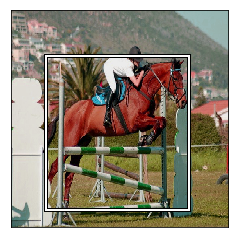

In [6]:
item = pas_bbox_train_dl.dataset[1]
plot_utils.plot_image_with_bbox(*item)

In [7]:
custom_head = nn.Sequential(
        Flatten(),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512*7*7, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),
        nn.Linear(256, 4)
    )

model = model_utils.get_resnet34_model_with_custom_head(custom_head) 

In [8]:
model.load_state_dict(torch.load(DATA_DIR/'my-models/largest_bbox_L1_loss_26.ckpt', map_location='cpu'))

In [ ]:
#unfreeze_all_layers(model)

In [ ]:
model.train()
n_epochs = 5
lr = 0.001
logger = model_utils.create_tensorboard_logger('./logs/largest_item_bbox/run_1')
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, labels in pas_bbox_train_dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        log_info = { 'MSE loss': loss.item() }
        model_utils.log_scalars_to_tensorboard_logger(logger, log_info, total_steps)                                                    
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(pas_bbox_train_dl))

In [9]:
pred_bboxes, batch, actual_labels = model_utils.get_model_predictions_on_a_sample_batch(model, pas_bbox_val_dl)    

In [9]:
#torch.save((pred_bboxes, batch, actual_labels), './Saved Tensors/largest_item_bbox_sample_preds_batch_labels.pt')
pred_bboxes, batch, actual_labels = torch.load('./Saved Tensors/largest_item_bbox_sample_preds_batch_labels.pt')

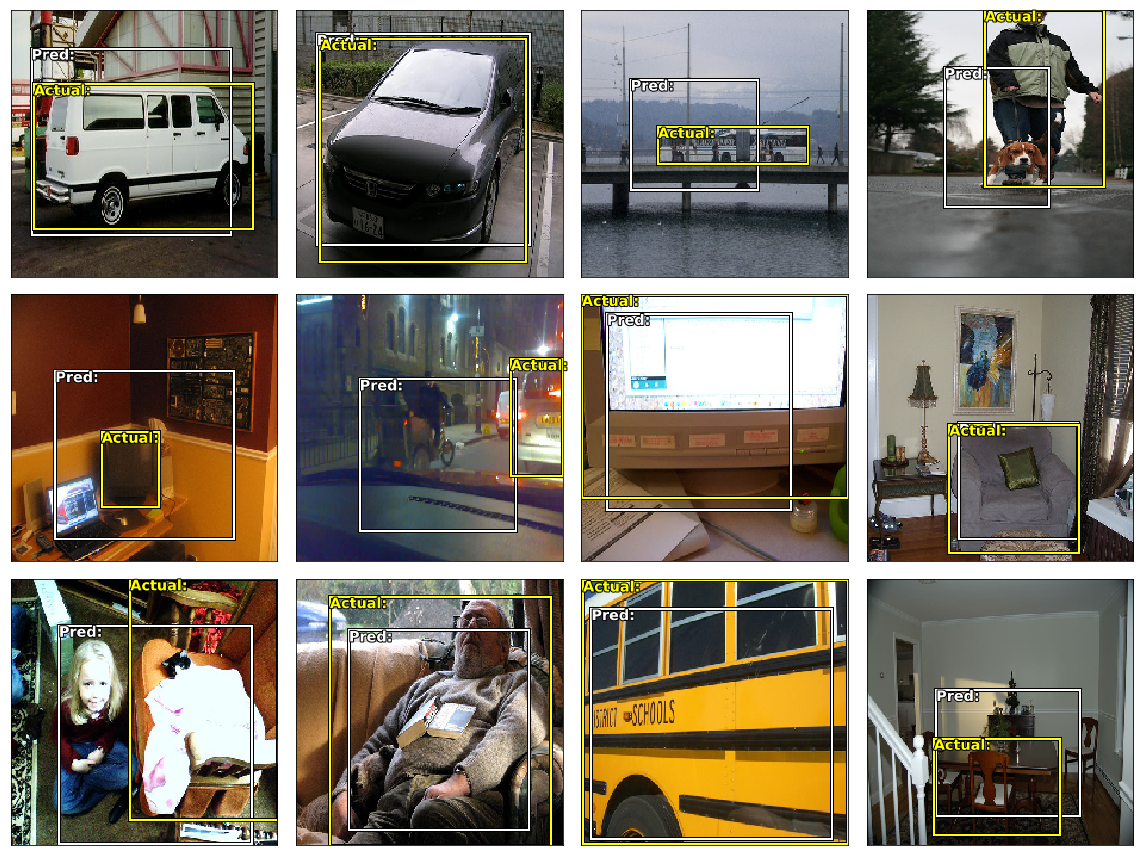

In [10]:
plot_utils.plot_bbox_model_predictions_on_sample_batch(batch, pred_bboxes, actual_labels)